In [51]:
from environment.blackjack import Blackjack

In [52]:
env = Blackjack()

In [53]:
import torch
import torch.nn as nn

In [54]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available else "cpu"
device = "cpu"
print(f"device: {device}")

device: cpu


In [55]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 4)
        )

    def forward(self, x):
        x_norm = x.clone()
        x_norm[:, 0] = x[:, 0] / 21.0
        x_norm[:, 1] = x[:, 1] / 11.0
        logits = self.layers(x_norm)
        return logits

In [56]:
torch.manual_seed(11)
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4, bias=True)
  )
)


In [57]:
import random
from collections import deque
class ReplayBuffer():
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))


    def sample(self, batch_size):
        return random.sample(self.buffer, min(batch_size, len(self.buffer)))


    def size(self):
        return len(self.buffer)

In [58]:
buffer = ReplayBuffer(100000)

In [59]:
def get_action(state, epsilon, double_possible, splittable):
    if random.random() < epsilon:
        return env.action_random(double_possible, splittable)

    with torch.no_grad():
        q_values = model(state[:, :3])
        if not double_possible:
            q_values[:, 2] = -99.0
        if not splittable:
            q_values[:, 3] = -99.0

    return torch.argmax(q_values).item()

In [60]:
import torch.nn.functional as F
def training(target_model):
    batch = zip(*buffer.sample(batch_size))

    state, action, reward, next_state, done = batch

    state = torch.stack(state).to(device).squeeze(1)
    action = torch.tensor(action).long().unsqueeze(1).to(device)
    reward = torch.tensor(reward).float().unsqueeze(1).to(device)
    next_state = torch.stack(next_state).to(device).squeeze(1)
    done = torch.tensor(done).float().unsqueeze(1).to(device)

    output = model(state[:, :3])
    label = output.gather(dim=1, index=action)

    with torch.no_grad():
        target_q_vals = target_model(next_state[:, :3])

        action_split = (action[:] == 3) + 1.0
        target_q_vals *= action_split

        cannot_double = (next_state[:, -2] == 0)
        cannot_split = (next_state[:, -1] == 0)

        target_q_vals[cannot_double, 2] = -99.0
        target_q_vals[cannot_split, 3] = -99.0
        future_move = torch.amax(target_q_vals, dim=1).unsqueeze(1)
        prediction = reward + (1 - done) * gamma * future_move
    loss = F.smooth_l1_loss(label, prediction)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [61]:
import copy
net_rewards = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 1000000
batch_size = 128
gamma = 1.0
epsilon = 1.0
target_model = copy.deepcopy(model)
model.train()
reward_sum = 0

for epoch in range(epochs):

    state = env.next_hand()

    state = torch.tensor(state, device=device).float().unsqueeze(0)
    done = False

    if epoch % 300 == 0:
        target_model.load_state_dict(model.state_dict())

    while not done:
        double_possible = state[:, -2]
        splittable = state[:, -1]

        if buffer.size() < 10 * batch_size:
            action = env.action_random(double_possible, splittable)
        else:
            action = get_action(state, epsilon, double_possible, splittable)

        next_state, reward, hand_over = env.step(action)
        if len(next_state) == 2:
            next_state = next_state[0]
        next_state = torch.tensor(next_state, device=device).float().unsqueeze(0)

        done = hand_over or action == 3

        buffer.push(state, action, reward, next_state, hand_over)

        state = next_state

    reward_sum += reward

    if buffer.size() < 10 * batch_size:
        continue

    loss = training(target_model)

    if epoch % 10000 == 0 and epoch != 0:
        print(f"epoch: {epoch} | reward net: {round(reward_sum)}")
        net_rewards.append(reward_sum/10000)
        reward_sum = 0

    if epoch < 0.75 * epochs:
        epsilon *= 0.999995
    else:
        epsilon = 0


epoch: 10000 | reward net: -4712
epoch: 20000 | reward net: -4665
epoch: 30000 | reward net: -4440
epoch: 40000 | reward net: -4315
epoch: 50000 | reward net: -4253
epoch: 60000 | reward net: -3997
epoch: 70000 | reward net: -3601
epoch: 80000 | reward net: -3587
epoch: 90000 | reward net: -3394
epoch: 100000 | reward net: -3399
epoch: 110000 | reward net: -3292
epoch: 120000 | reward net: -2985
epoch: 130000 | reward net: -2897
epoch: 140000 | reward net: -2720
epoch: 150000 | reward net: -2581
epoch: 160000 | reward net: -2421
epoch: 170000 | reward net: -2536
epoch: 180000 | reward net: -2490
epoch: 190000 | reward net: -2250
epoch: 200000 | reward net: -2060
epoch: 210000 | reward net: -2224
epoch: 220000 | reward net: -1953
epoch: 230000 | reward net: -2042
epoch: 240000 | reward net: -1945
epoch: 250000 | reward net: -1983
epoch: 260000 | reward net: -1911
epoch: 270000 | reward net: -1591
epoch: 280000 | reward net: -1626
epoch: 290000 | reward net: -1351
epoch: 300000 | reward 

In [88]:
state = env.next_hand()
state = (4, 2, 0)
print(state)
state = torch.tensor(state, device=device).float().unsqueeze(0)
output = model(state)
print(output)
action = torch.argmax(output).item()

(4, 2, 0)
tensor([[-0.7296, -0.1354, -0.3872, -0.6579]], grad_fn=<AddmmBackward0>)


In [89]:
games = 100000
model.eval()
wins = 0
draws = 0
losses = 0
net_score = 0
for game in range(games):
    state = env.next_hand()
    state = torch.tensor(state, device=device).float().unsqueeze(0)
    done = False

    while not done:

        with torch.no_grad():
            q_values = model(state[:, :3])
            if state[0, -2] == 0:
                q_values[0, -2] = -99
            if state[0, -1] == 0:
                q_values[0, -1] = -99

            action = torch.argmax(q_values).item()

        if action == 3:
            _ = env.step(action)
            next_state = env.next_hand()
            terminated = False

        else:
            next_state, reward, terminated = env.step(action)

        next_state = torch.tensor(next_state, device=device).float().unsqueeze(0)

        done = terminated

        state = next_state

    if reward > 0:
        wins += 1
    elif reward == 0:
        draws += 1
    else:
        losses += 1

    net_score += reward

print(f"Wins: {wins} | Draws: {draws} | Losses: {losses}")
print(f"Win Accuracy: {(wins/games)*100:.2f}% | Draw Accuracy: {(draws/games)*100:.2f}% | Loss Accuracy: {(losses/games)*100:.2f}%")
print(f"Net Score: {net_score}")

Wins: 41774 | Draws: 9179 | Losses: 49047
Win Accuracy: 41.77% | Draw Accuracy: 9.18% | Loss Accuracy: 49.05%
Net Score: -4423.0


In [64]:
torch.save(model.state_dict(), "blackjack_model_weights.pth")

<function matplotlib.pyplot.show(close=None, block=None)>

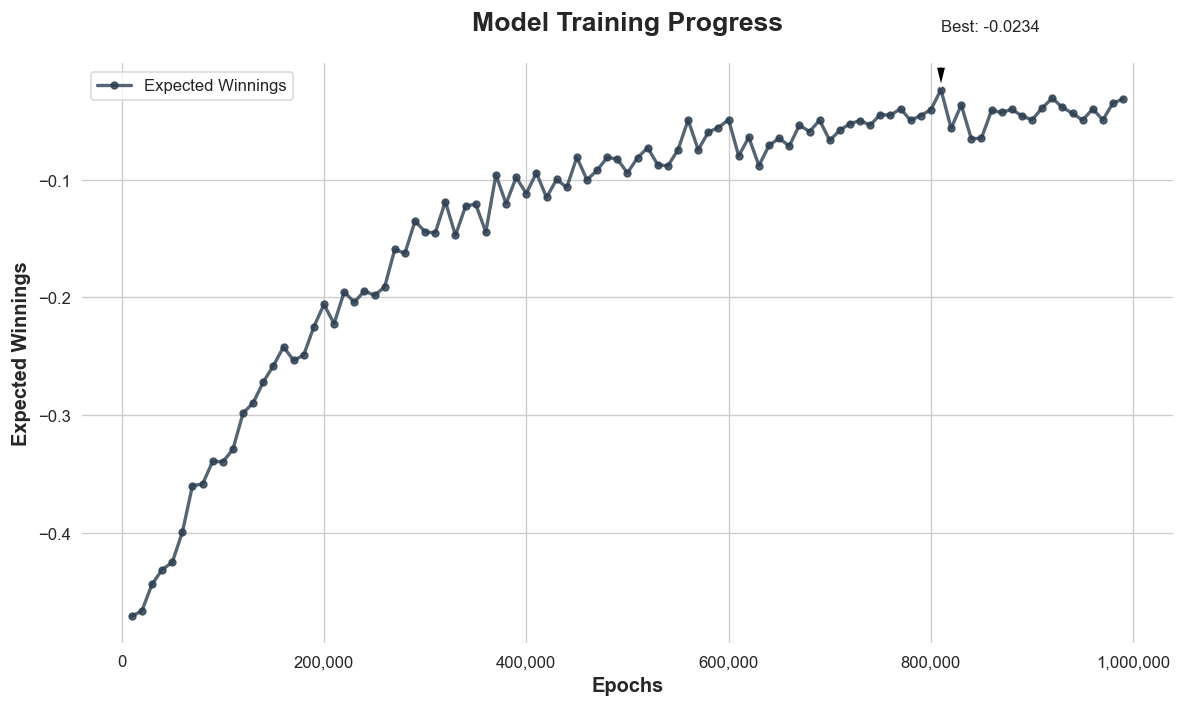

In [95]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6), dpi=120)

epochs = range(10000, 1000000, 10000)

plt.plot(epochs, net_rewards, "o-", color="#2c3e50", label="Expected Winnings", linewidth=2, markersize=4, alpha=0.8)

ax = plt.gca()
ax.xaxis.set_minor_locator(ticker.MultipleLocator(200000))
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

plt.title("Model Training Progress", fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Epochs", fontsize=12, fontweight="semibold")
plt.ylabel("Expected Winnings", fontsize=12, fontweight="semibold")

plt.legend(frameon=True, facecolor="white", edgecolor="lightgray")

sns.despine(left=True, bottom=True)
max_reward = max(net_rewards)
max_epoch = epochs[net_rewards.index(max_reward)]
plt.annotate(f'Best: {max_reward:.4f}',
                 xy=(max_epoch, max_reward),
                 xytext=(max_epoch + 1, max_reward + 0.05),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6))



plt.tight_layout()
plt.show